In [9]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
!pip install x-unet
!pip install scikit-learn
!pip install scikit-image

DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can b

In [11]:
import random
import torch
import os

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [12]:
import os

data_path = '/users/kolodny/gyanai/LF-MRI-Denoising/Data'
png_folder = os.path.join(data_path, 'Images')

checkpoints_path = '/users/kolodny/gyanai/LF-MRI-Denoising/checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

class HighFrequencyDataset(Dataset):
    def __init__(self, images_path):
        self.images_path = images_path
        self.images = self.read_images()

    def read_images(self) -> torch.Tensor:
        image_file_paths = [f for f in os.listdir(self.images_path) if f.lower().endswith('.png')]
        images = [Image.open(os.path.join(self.images_path, img_path)) for img_path in image_file_paths]
        return self.transform_images(images)

    def transform_images(self, images: list[Image]) -> torch.Tensor:
        transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
        return torch.stack([transform(image) for image in images])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx) -> torch.Tensor:
        return self.images[idx]


In [14]:
dataset = HighFrequencyDataset(png_folder)

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [16]:
import torch


def add_gaussian_noise(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(x) * sigmas
    return x + noise, sigmas

def add_rician_noise(img: torch.Tensor, max_sigma: float, min_sigma: float = 0) -> tuple[torch.Tensor, float]:
    """
    Add Rician noise to an image tensor.

    Args:
        img (torch.Tensor): Input image (float tensor).
        sigma (float): Standard deviation of the underlying Gaussian noise.

    Returns:
        torch.Tensor: Noisy image with Rician-distributed values.
    """
    sigma = torch.rand(1).item() * (max_sigma - min_sigma) + min_sigma
    # Generate Gaussian noise with mean=0, std=sigma
    n1 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)
    n2 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)

    # Apply Rician formula
    noisy_img = torch.sqrt((img + n1) ** 2 + n2 ** 2)

    return noisy_img, sigma

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

In [17]:
import torch
import torch.nn as nn
from x_unet import XUnet

# Create an instance of the XUnet model
unet = XUnet(
    dim=64,
    channels=1,
    dim_mults=(1, 2, 4, 8),
    nested_unet_depths=(7, 4, 2, 1),  # nested unet depths, from unet-squared paper
    consolidate_upsample_fmaps=True,  # whether to consolidate outputs from all upsample blocks, used in unet-squared paper
)

unet = nn.Sequential(unet, nn.Sigmoid())

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = unet.to(device)

In [19]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Define optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [20]:
# K space

def fft2_image(x):
    # x: [B, C, H, W] torch tensor
    return torch.fft.fft2(x, norm='ortho')

def ifft2_image(k):
    # k: [B, C, H, W] complex tensor
    return torch.fft.ifft2(k, norm='ortho').real

def add_gaussian_noise_kspace(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    """
    Add Gaussian noise in K-space to a batch of images.
    """
    kspace = fft2_image(x)
    # Create noise tensor of same shape
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(kspace) * sigmas
    noisy_kspace = kspace + noise
    x_noisy = ifft2_image(noisy_kspace)
    return x_noisy, sigmas


In [21]:
import torch.nn as nn

# Define the loss function
mse_loss = nn.MSELoss()

In [22]:
from tqdm import tqdm
import torch.nn.functional as F

NOISE_STD = 0.08
EPOCHS = 5
MODEL_OUT_DIR = os.path.join(checkpoints_path, 'vanilla')

os.makedirs(MODEL_OUT_DIR, exist_ok=True)


best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    unet.train()
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")

    train_loss = 0.0

    for x in pbar:
        x = x.to(device)          # clean target in [-1,1]
        x_noisy, _ = add_gaussian_noise_kspace(x, NOISE_STD)
        pred_noise = unet(x_noisy)          # predict clean image directly
        pred = x_noisy - pred_noise
        loss = mse_loss(pred, x)     # MSE loss
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch} | train {train_loss:.4f}")

    # validation
    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv in iter(val_loader):
            xv = xv.to(device)
            xv_noisy, _ = add_gaussian_noise_kspace(xv, NOISE_STD)
            pred_noise = unet(xv_noisy)
            pred = xv_noisy - pred_noise
            val_loss += mse_loss(pred, xv).item()
    val_loss /= len(val_loader)

    # track best
    if val_loss < best_val:
        best_val = val_loss
        torch.save(unet.state_dict(), os.path.join(MODEL_OUT_DIR, "best_model.pt"))

    print(f"Epoch {epoch} | val {val_loss:.4f} | best {best_val:.4f}")

Epoch 1/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:10<00:00,  1.91it/s, loss=0.0016]


Epoch 1 | train 0.0012
Epoch 1 | val 0.0011 | best 0.0011


Epoch 2/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:09<00:00,  1.91it/s, loss=0.0012]


Epoch 2 | train 0.0011
Epoch 2 | val 0.0010 | best 0.0010


Epoch 3/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:09<00:00,  1.91it/s, loss=0.0012]


Epoch 3 | train 0.0011
Epoch 3 | val 0.0011 | best 0.0010


Epoch 4/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:09<00:00,  1.91it/s, loss=0.0012]


Epoch 4 | train 0.0011
Epoch 4 | val 0.0011 | best 0.0010


Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [14:09<00:00,  1.91it/s, loss=0.0018]


Epoch 5 | train 0.0011
Epoch 5 | val 0.0011 | best 0.0010


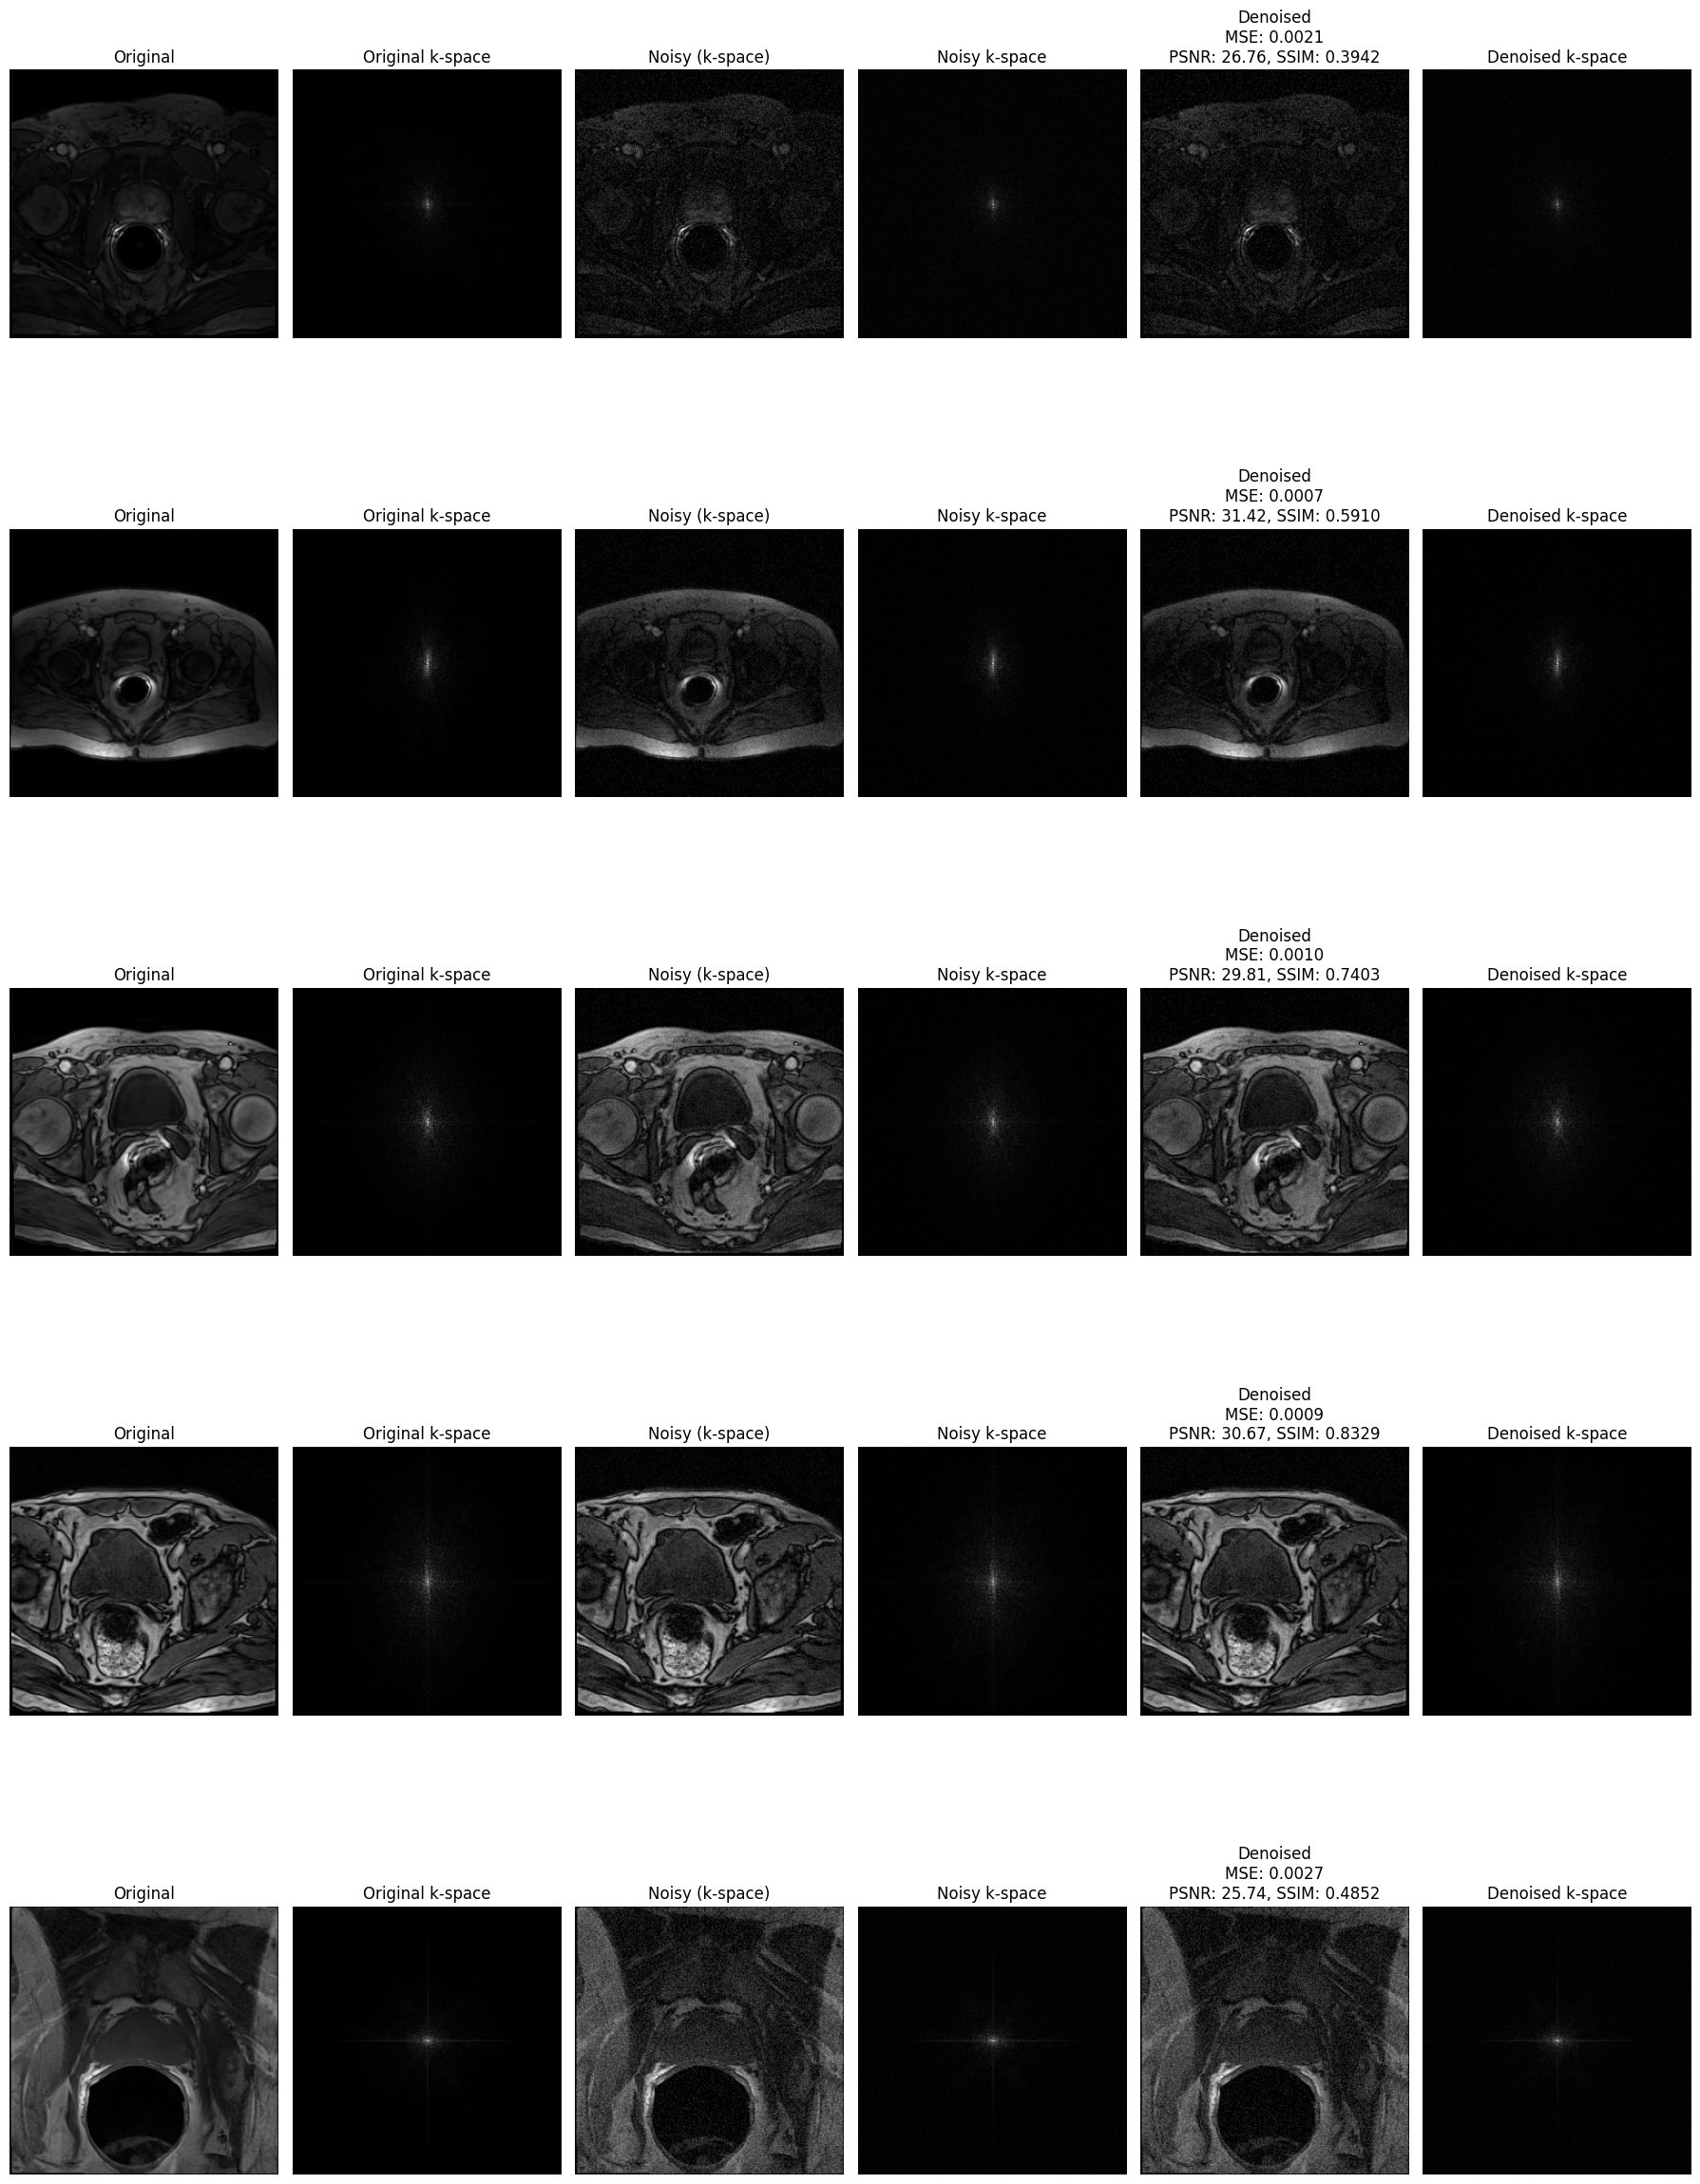

In [23]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def fft2c(x: torch.Tensor) -> torch.Tensor:
    """Centered 2D FFT"""
    x = x.to(torch.complex64)
    x = torch.fft.ifftshift(x, dim=(-2, -1))
    k = torch.fft.fft2(x, dim=(-2, -1), norm="ortho")
    return torch.fft.fftshift(k, dim=(-2, -1))

def kspace_logmag(k: torch.Tensor) -> torch.Tensor:
    """Log-magnitude normalized to [0,1] for display"""
    mag = torch.log1p(k.abs())
    m = mag.amin(dim=(-2, -1), keepdim=True)
    M = mag.amax(dim=(-2, -1), keepdim=True)
    return ((mag - m) / (M - m + 1e-8)).clamp(0, 1)

# ---- visualization ----
batch = next(iter(val_loader))
if isinstance(batch, (list, tuple)):
    batch = batch[0]
vd = batch.to(device)

random_indices = torch.randint(0, vd.size(0), (5,))
plt.figure(figsize=(18, 25))

_ = unet.eval()

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        xv = vd[idx].unsqueeze(0)  # (1,1,H,W)

        # Original k-space
        k_clean = fft2c(xv)

        # Add noise in k-space
        xv_noisy, _ = add_gaussian_noise_kspace(xv, max_sigma=0.08, min_sigma=0.03)
        k_noisy = fft2c(xv_noisy)

        # Denoise
        pred_noise = unet(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        k_pred = fft2c(pred)

        # --- Plotting ---
        plt.subplot(5, 6, i * 6 + 1)
        plt.imshow(xv.cpu().squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 2)
        plt.imshow(kspace_logmag(k_clean).cpu().squeeze(), cmap="gray")
        plt.title("Original k-space")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 3)
        plt.imshow(xv_noisy.clamp(0, 1).cpu().squeeze(), cmap="gray")
        plt.title("Noisy (k-space)")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 4)
        plt.imshow(kspace_logmag(k_noisy).cpu().squeeze(), cmap="gray")
        plt.title("Noisy k-space")
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 5)
        plt.imshow(pred.cpu().squeeze(), cmap="gray")
        plt.title(
            f"Denoised\n"
            f"MSE: {mse_loss(pred, xv).item():.4f}\n"
            f"PSNR: {compute_psnr(xv.squeeze(), pred.squeeze()):.2f}, "
            f"SSIM: {compute_ssim(xv.squeeze(), pred.squeeze()):.4f}"
        )
        plt.axis("off")

        plt.subplot(5, 6, i * 6 + 6)
        plt.imshow(kspace_logmag(k_pred).cpu().squeeze(), cmap="gray")
        plt.title("Denoised k-space")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [24]:
validation_loss = []
validation_psnr = []
validation_ssim = []

for xv in tqdm(vd):
    with torch.no_grad():
        # Original k-space
        k_clean = fft2c(xv)

        # Add noise in k-space
        xv_noisy, _ = add_gaussian_noise_kspace(xv, max_sigma=0.08, min_sigma=0.03)
        k_noisy = fft2c(xv_noisy)

        # Denoise
        pred_noise = unet(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        

    validation_loss.append(mse_loss(xv, pred).item())
    validation_psnr.append(compute_psnr(xv.squeeze(), pred.squeeze()))
    validation_ssim.append(compute_ssim(xv.squeeze(), pred.squeeze()))

print(f"Validation Loss: {sum(validation_loss)/len(validation_loss)}")
print(f"Validation PSNR: {sum(validation_psnr)/len(validation_psnr)}")
print(f"Validation SSIM: {sum(validation_ssim)/len(validation_ssim)}")

  0%|                                                                                                                                                                               | 0/16 [00:00<?, ?it/s]/users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.42it/s]

Validation Loss: 0.001244040144229075
Validation PSNR: 29.561282040337947
Validation SSIM: 0.555768995785676
